# F1 Strategy Prediction & Predictive Maintenance
## Project Step 1: Data Analysis, Preprocessing, Problem Formalization & Baseline Model

**Authors:** [John Liu, Timothée Mariotte, Matthieu Puiseux] 

## 1. INSTALLATION & IMPORTS

In [1]:
# !pip install fastf1 pandas numpy scikit-learn matplotlib seaborn

import warnings, os
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from pathlib import Path
import fastf1


# Current folder if notebook opened in the folder "project_ML"
BASE_DIR = Path.cwd()

cache_dir = BASE_DIR / "f1_cache"
if cache_dir.exists() and not cache_dir.is_dir():
    raise RuntimeError(f"{cache_dir} existe mais n'est pas un dossier.")
cache_dir.mkdir(parents=True, exist_ok=True)

fastf1.Cache.enable_cache(str(cache_dir))
print("Cache activé:", cache_dir)
print("CWD =", os.getcwd())
print("Imports successful")
print("FastF1 version:", fastf1.__version__)


Cache activé: C:\Users\mario\Desktop\projet_ML\f1_cache
CWD = C:\Users\mario\Desktop\projet_ML
Imports successful
FastF1 version: 3.6.1


## 2. DATA LOADING

In [2]:
print("\n" + "="*80)
print("LOADING F1 DATA")
print("="*80)

# Chargement d'une course récente (2024 - Bahrain GP)
session = fastf1.get_session(2024, 'Bahrain', 'R')
session.load()

print(f"Loaded: {session.event['EventName']} - {session.name}")
print(f"Date: {session.event['EventDate']}")

# Récupération des données télémétrie
laps = session.laps
print(f"\nTotal laps in race: {len(laps)}")
print(f"Drivers: {laps['Driver'].nunique()}")


LOADING F1 DATA


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']


Loaded: Bahrain Grand Prix - Race
Date: 2024-03-02 00:00:00

Total laps in race: 1129
Drivers: 20


## 3. DESCRIPTIVE ANALYSIS

In [3]:
print("\n" + "="*80)
print("1. DESCRIPTIVE ANALYSIS")
print("="*80)

# 1.1 Dataset Overview
print("\n--- Dataset Structure ---")
print(f"Shape: {laps.shape}")
print(f"\nColumns ({len(laps.columns)}):")
print(laps.columns.tolist())

# 1.2 Key Statistics
print("\n--- Key Statistics ---")
key_cols = ['LapTime', 'LapNumber', 'Stint', 'TyreLife', 'Compound', 
            'TrackStatus', 'IsAccurate', 'PitOutTime', 'PitInTime']
available_cols = [col for col in key_cols if col in laps.columns]
print(laps[available_cols].describe())

# 1.3 Missing Values Analysis
print("\n--- Missing Values ---")
missing = laps[available_cols].isnull().sum()
missing_pct = (missing / len(laps) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

# 1.4 Tire Compound Distribution
print("\n--- Tire Compound Usage ---")
if 'Compound' in laps.columns:
    print(laps['Compound'].value_counts())

# 1.5 Pit Stop Analysis
print("\n--- Pit Stop Statistics ---")
pit_stops = laps[laps['PitInTime'].notna()]
print(f"Total pit stops: {len(pit_stops)}")
print(f"Average pit stops per driver: {len(pit_stops) / laps['Driver'].nunique():.2f}")


1. DESCRIPTIVE ANALYSIS

--- Dataset Structure ---
Shape: (1129, 31)

Columns (31):
['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate']

--- Key Statistics ---
                         LapTime    LapNumber        Stint     TyreLife  \
count                       1127  1129.000000  1129.000000  1129.000000   
mean   0 days 00:01:38.004108251    28.728078     2.260407    10.705934   
std    0 days 00:00:04.500312960    16.305688     0.825910     6.277025   
min       0 days 00:01:32.608000     1.000000     1.000000     1.000000   
25%       0 days 00:01:36.131000    15.000000     2.000000     6.000000   
50%     


Visualizations saved as 'descriptive_analysis.png'


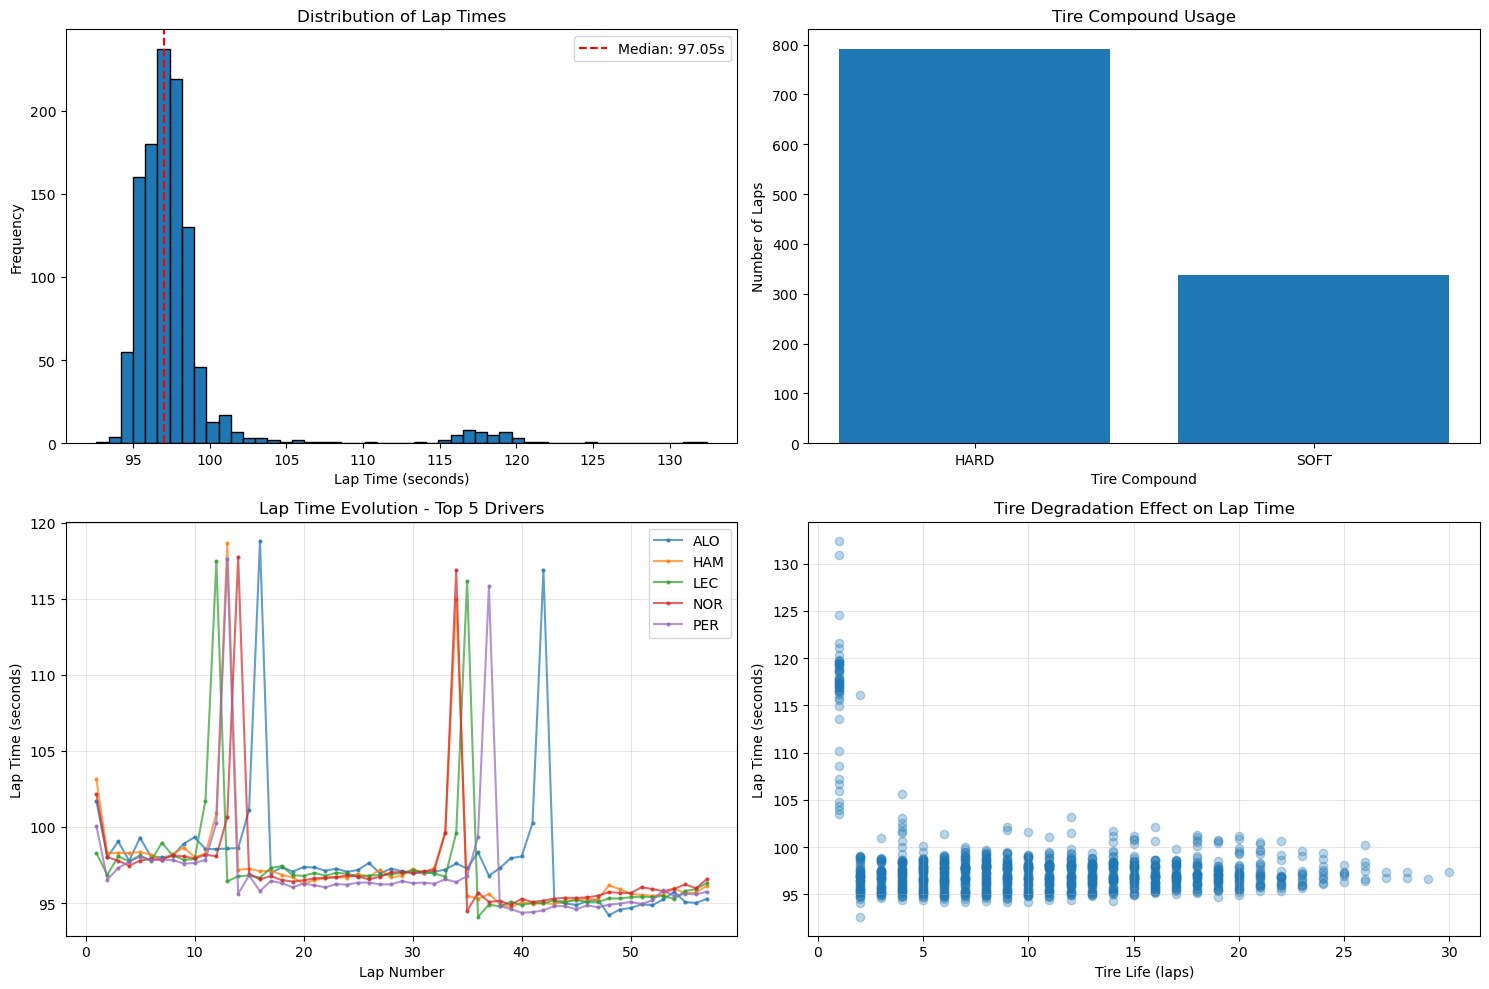

In [4]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Lap times distribution
if 'LapTime' in laps.columns:
    lap_times_sec = laps['LapTime'].dt.total_seconds()
    axes[0, 0].hist(lap_times_sec.dropna(), bins=50, edgecolor='black')
    axes[0, 0].set_xlabel('Lap Time (seconds)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Lap Times')
    axes[0, 0].axvline(lap_times_sec.median(), color='red', 
                       linestyle='--', label=f'Median: {lap_times_sec.median():.2f}s')
    axes[0, 0].legend()

# Plot 2: Tire compound usage
if 'Compound' in laps.columns:
    compound_counts = laps['Compound'].value_counts()
    axes[0, 1].bar(compound_counts.index, compound_counts.values)
    axes[0, 1].set_xlabel('Tire Compound')
    axes[0, 1].set_ylabel('Number of Laps')
    axes[0, 1].set_title('Tire Compound Usage')

# Plot 3: Lap times evolution per driver (top 5)
if 'LapTime' in laps.columns and 'Driver' in laps.columns:
    top_drivers = laps.groupby('Driver')['LapNumber'].count().nlargest(5).index
    for driver in top_drivers:
        driver_laps = laps[laps['Driver'] == driver]
        lap_times = driver_laps['LapTime'].dt.total_seconds()
        axes[1, 0].plot(driver_laps['LapNumber'], lap_times, 
                       marker='o', markersize=2, label=driver, alpha=0.7)
    axes[1, 0].set_xlabel('Lap Number')
    axes[1, 0].set_ylabel('Lap Time (seconds)')
    axes[1, 0].set_title('Lap Time Evolution - Top 5 Drivers')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Tire life vs Lap time
if 'TyreLife' in laps.columns and 'LapTime' in laps.columns:
    valid_data = laps[['TyreLife', 'LapTime']].dropna()
    lap_times = valid_data['LapTime'].dt.total_seconds()
    axes[1, 1].scatter(valid_data['TyreLife'], lap_times, alpha=0.3)
    axes[1, 1].set_xlabel('Tire Life (laps)')
    axes[1, 1].set_ylabel('Lap Time (seconds)')
    axes[1, 1].set_title('Tire Degradation Effect on Lap Time')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('descriptive_analysis.png', dpi=300, bbox_inches='tight')
print("\nVisualizations saved as 'descriptive_analysis.png'")

## 4. DATA PREPROCESSING

In [5]:
print("\n" + "="*80)
print("2. DATA PREPROCESSING")
print("="*80)

# 2.1 Create working dataframe
df = laps.copy()

# 2.2 Convert LapTime to seconds
if 'LapTime' in df.columns:
    df['LapTime_sec'] = df['LapTime'].dt.total_seconds()
    print(f"Converted LapTime to seconds")

# 2.3 Handle categorical variables
if 'Compound' in df.columns:
    # Encode tire compounds
    compound_mapping = {'SOFT': 0, 'MEDIUM': 1, 'HARD': 2, 'INTERMEDIATE': 3, 'WET': 4}
    df['Compound_encoded'] = df['Compound'].map(compound_mapping)
    print(f"Encoded Compound: {compound_mapping}")

# 2.4 Create pit stop indicator
df['IsPitLap'] = df['PitInTime'].notna().astype(int)
print(f"Created pit stop indicator: {df['IsPitLap'].sum()} pit laps")

# 2.5 Handle missing values
# For numeric features, use forward fill then backward fill
numeric_features = ['TyreLife', 'Stint', 'LapTime_sec', 'Compound_encoded']
for feature in numeric_features:
    if feature in df.columns:
        before = df[feature].isnull().sum()
        df[feature] = df[feature].fillna(method='ffill').fillna(method='bfill')
        after = df[feature].isnull().sum()
        print(f"{feature}: {before} → {after} missing values")

# 2.6 Remove outliers (lap times > Q3 + 3*IQR)
if 'LapTime_sec' in df.columns:
    Q1 = df['LapTime_sec'].quantile(0.25)
    Q3 = df['LapTime_sec'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    outliers = df[(df['LapTime_sec'] < lower_bound) | (df['LapTime_sec'] > upper_bound)]
    print(f"\nOutliers detected: {len(outliers)} laps ({len(outliers)/len(df)*100:.2f}%)")
    
    df_clean = df[(df['LapTime_sec'] >= lower_bound) & (df['LapTime_sec'] <= upper_bound)]
    print(f"Dataset after outlier removal: {len(df_clean)} laps")
else:
    df_clean = df

# 2.7 Feature Engineering
print("\n--- Feature Engineering ---")

# Tire degradation indicator
if 'TyreLife' in df_clean.columns and 'LapTime_sec' in df_clean.columns:
    df_clean['TireDegradation'] = df_clean['TyreLife'] * df_clean['LapTime_sec']
    print("Created TireDegradation feature")

# Lap progress (0 to 1)
if 'LapNumber' in df_clean.columns:
    max_lap = df_clean['LapNumber'].max()
    df_clean['LapProgress'] = df_clean['LapNumber'] / max_lap
    print("Created LapProgress feature")


2. DATA PREPROCESSING
Converted LapTime to seconds
Encoded Compound: {'SOFT': 0, 'MEDIUM': 1, 'HARD': 2, 'INTERMEDIATE': 3, 'WET': 4}
Created pit stop indicator: 43 pit laps
TyreLife: 0 → 0 missing values
Stint: 0 → 0 missing values
LapTime_sec: 2 → 0 missing values
Compound_encoded: 0 → 0 missing values

Outliers detected: 51 laps (4.52%)
Dataset after outlier removal: 1078 laps

--- Feature Engineering ---
Created TireDegradation feature
Created LapProgress feature


## 5. PROBLEM FORMALIZATION

In [6]:
print("\n" + "="*80)
print("3. PROBLEM FORMALIZATION")
print("="*80)

print("""
DUAL PIPELINE APPROACH:

A. STRATEGY PREDICTION (Supervised Learning - Classification)
   - Objective: Predict optimal pit stop timing and tire strategy
   - Target: Predict if next lap will be a pit stop (binary classification)
   - Features: Lap number, tire life, compound, lap time, stint info
   - Algorithms: Random Forest, Gradient Boosting, Neural Networks
   - Evaluation: Accuracy, Precision, Recall, F1-Score, ROC-AUC

B. ANOMALY DETECTION (Unsupervised Learning)
   - Objective: Detect unusual telemetry patterns for predictive maintenance
   - Target: Identify anomalous laps (no labels required)
   - Features: Lap time deviations, tire degradation, performance metrics
   - Algorithms: Isolation Forest, Autoencoders, One-Class SVM
   - Evaluation: Anomaly score distribution, visual inspection

DATASETS AVAILABLE:
   - Historical data: 2018-2024 (7 complete seasons)
   - ~23 races per season, ~20 drivers per race
   - ~800 MB to 1.5 GB telemetry per race (200+ sensors @ 10Hz)
   - Features: Speed, RPM, throttle, brake, GPS, tire data, weather

IOT INTEGRATION:
   - Real-time streaming: Multi-sensor telemetry
   - Edge computing: Strategy suggestions during race
   - Fleet management: Cross-driver performance analysis
""")


3. PROBLEM FORMALIZATION

DUAL PIPELINE APPROACH:

A. STRATEGY PREDICTION (Supervised Learning - Classification)
   - Objective: Predict optimal pit stop timing and tire strategy
   - Target: Predict if next lap will be a pit stop (binary classification)
   - Features: Lap number, tire life, compound, lap time, stint info
   - Algorithms: Random Forest, Gradient Boosting, Neural Networks
   - Evaluation: Accuracy, Precision, Recall, F1-Score, ROC-AUC

B. ANOMALY DETECTION (Unsupervised Learning)
   - Objective: Detect unusual telemetry patterns for predictive maintenance
   - Target: Identify anomalous laps (no labels required)
   - Features: Lap time deviations, tire degradation, performance metrics
   - Algorithms: Isolation Forest, Autoencoders, One-Class SVM
   - Evaluation: Anomaly score distribution, visual inspection

DATASETS AVAILABLE:
   - Historical data: 2018-2024 (7 complete seasons)
   - ~23 races per season, ~20 drivers per race
   - ~800 MB to 1.5 GB telemetry per race

## 6. BASELINE MODEL IMPLEMENTATION


4. BASELINE MODEL IMPLEMENTATION

--- PIPELINE A: PIT STOP PREDICTION ---

Dataset for modeling:
   - Features: ['LapNumber', 'TyreLife', 'Compound_encoded', 'Stint', 'LapTime_sec', 'LapProgress']
   - Samples: 1058
   - Target distribution: {0: 1016, 1: 42}
   - Class balance: 3.97% pit stops

Train set: 846 samples
Test set: 212 samples

Training Random Forest Classifier...

BASELINE MODEL RESULTS:
Accuracy: 0.9481

Classification Report:
              precision    recall  f1-score   support

 No Pit Stop       0.97      0.98      0.97       204
    Pit Stop       0.29      0.25      0.27         8

    accuracy                           0.95       212
   macro avg       0.63      0.61      0.62       212
weighted avg       0.94      0.95      0.95       212


Feature Importance:
         Feature  Importance
        TyreLife    0.304767
     LapTime_sec    0.285595
       LapNumber    0.154377
     LapProgress    0.154067
           Stint    0.081029
Compound_encoded    0.020165
Con

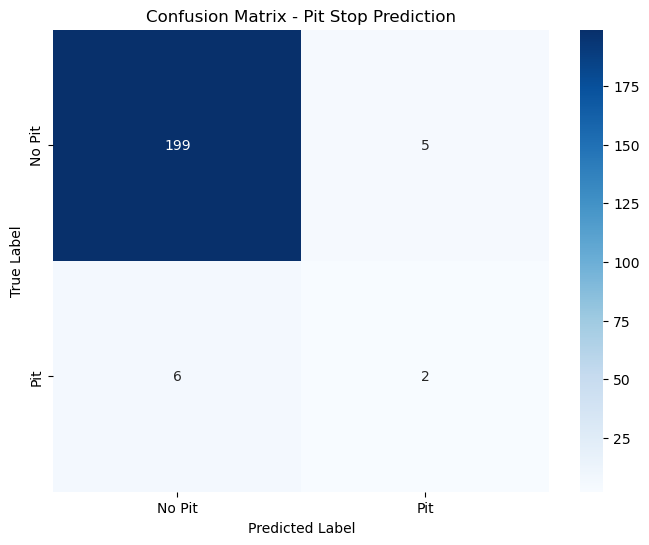

In [7]:
print("\n" + "="*80)
print("4. BASELINE MODEL IMPLEMENTATION")
print("="*80)

# 4.1 PIPELINE A: Strategy Prediction (Pit Stop Classification)
print("\n--- PIPELINE A: PIT STOP PREDICTION ---")

# Select features for pit stop prediction
feature_cols = ['LapNumber', 'TyreLife', 'Compound_encoded', 'Stint', 
                'LapTime_sec', 'LapProgress']
available_features = [col for col in feature_cols if col in df_clean.columns]

# Create target: predict if NEXT lap will be a pit stop
df_clean = df_clean.sort_values(['Driver', 'LapNumber'])
df_clean['NextLapIsPit'] = df_clean.groupby('Driver')['IsPitLap'].shift(-1)

# Remove last lap of each driver (no "next lap")
df_model = df_clean.dropna(subset=['NextLapIsPit'] + available_features)

X = df_model[available_features]
y = df_model['NextLapIsPit'].astype(int)

print(f"\nDataset for modeling:")
print(f"   - Features: {available_features}")
print(f"   - Samples: {len(X)}")
print(f"   - Target distribution: {y.value_counts().to_dict()}")
print(f"   - Class balance: {y.mean()*100:.2f}% pit stops")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline Model: Random Forest
print("\nTraining Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

# Evaluation
print("\nBASELINE MODEL RESULTS:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['No Pit Stop', 'Pit Stop']))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance.to_string(index=False))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Pit', 'Pit'],
            yticklabels=['No Pit', 'Pit'])
plt.title('Confusion Matrix - Pit Stop Prediction')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_baseline.png', dpi=300, bbox_inches='tight')
print("Confusion matrix saved")



--- PIPELINE B: ANOMALY DETECTION ---

Anomaly detection dataset:
   - Features: ['LapTime_sec', 'TyreLife', 'TireDegradation']
   - Samples: 1078

Training Isolation Forest...

ANOMALY DETECTION RESULTS:
   - Anomalies detected: 108 (10.02%)
   - Normal laps: 970
Anomaly visualization saved


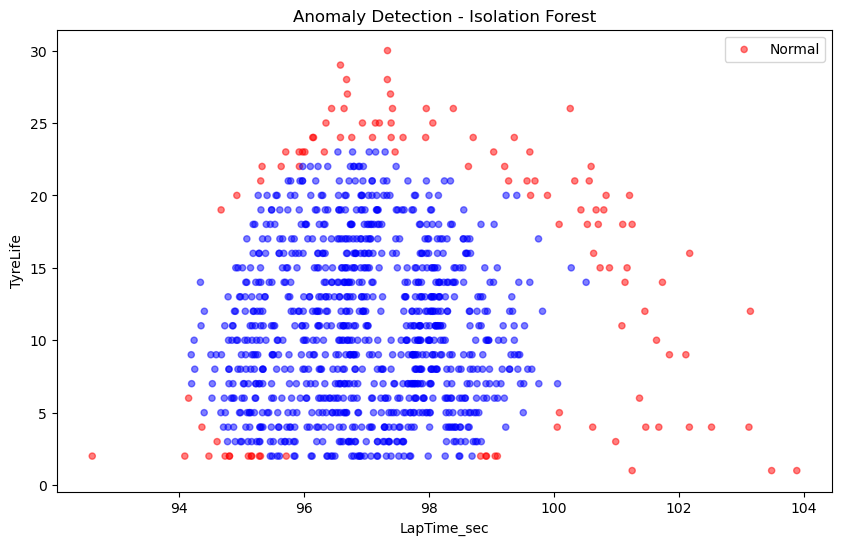

In [8]:
# 4.2 PIPELINE B: Anomaly Detection
print("\n\n--- PIPELINE B: ANOMALY DETECTION ---")

# Use lap time deviation as anomaly indicator
anomaly_features = ['LapTime_sec', 'TyreLife', 'TireDegradation']
available_anomaly_features = [f for f in anomaly_features if f in df_clean.columns]

X_anomaly = df_clean[available_anomaly_features].dropna()

print(f"\nAnomaly detection dataset:")
print(f"   - Features: {available_anomaly_features}")
print(f"   - Samples: {len(X_anomaly)}")

# Normalize features
scaler_anomaly = StandardScaler()
X_anomaly_scaled = scaler_anomaly.fit_transform(X_anomaly)

# Isolation Forest
print("\nTraining Isolation Forest...")
iso_forest = IsolationForest(
    contamination=0.1,  # Assume 10% anomalies
    random_state=42,
    n_jobs=-1
)

anomaly_pred = iso_forest.fit_predict(X_anomaly_scaled)
anomaly_scores = iso_forest.score_samples(X_anomaly_scaled)

# Results
n_anomalies = (anomaly_pred == -1).sum()
print(f"\nANOMALY DETECTION RESULTS:")
print(f"   - Anomalies detected: {n_anomalies} ({n_anomalies/len(X_anomaly)*100:.2f}%)")
print(f"   - Normal laps: {(anomaly_pred == 1).sum()}")

# Visualize anomalies
if len(available_anomaly_features) >= 2:
    plt.figure(figsize=(10, 6))
    colors = ['blue' if x == 1 else 'red' for x in anomaly_pred]
    plt.scatter(X_anomaly.iloc[:, 0], X_anomaly.iloc[:, 1], 
               c=colors, alpha=0.5, s=20)
    plt.xlabel(available_anomaly_features[0])
    plt.ylabel(available_anomaly_features[1])
    plt.title('Anomaly Detection - Isolation Forest')
    plt.legend(['Normal', 'Anomaly'])
    plt.savefig('anomaly_detection.png', dpi=300, bbox_inches='tight')
    print("Anomaly visualization saved")

## SUMMARY & NEXT STEPS

# SUMMARY & RECOMMENDATIONS

## Completed Tasks

1. **Descriptive Analysis**
   - Loaded and explored F1 race data
   - Analyzed lap times, tire usage, pit stops
   - Created visualizations

2. **Preprocessing**
   - Converted time features
   - Encoded categorical variables
   - Handled missing values
   - Removed outliers
   - Engineered new features

3. **Problem Formalization**
   - Defined dual pipeline approach
   - Strategy prediction (classification)
   - Anomaly detection (unsupervised)

4. **Baseline Model**
   - Random Forest for pit stop prediction
   - Isolation Forest for anomaly detection
   - Performance metrics computed

---

## Next Steps for Project Continuation

**Feature Engineering**
- Add telemetry data (speed, RPM, G-forces)
- Engineer more sophisticated features
- Temporal features (rolling averages)

**Model Optimization**
- Hyperparameter tuning (GridSearchCV)
- Test XGBoost, LightGBM
- Neural networks for time series

**Advanced Models**
- LSTM for sequence prediction
- Autoencoders for anomaly detection
- Ensemble methods

**Dashboard & Deployment**
- Real-time visualization (Plotly/Streamlit)
- Model deployment pipeline
- Final presentation

---

## Key Insights
- Tire life is crucial for pit stop prediction
- Lap time variations indicate potential issues
- Need more telemetry data for robust predictions

